In [4]:
# Import libraries and functions

from __future__ import print_function
import numpy as np
from scipy.io import loadmat
np.random.seed(1337)  # for reproducibility

import csv
import os,random

from keras.models import Model
from keras.layers import Input, LSTM
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
now = datetime.datetime.now


In [5]:
# length of data sequences
timesteps = [240, 194, 213, 250, 264, 170, 231, 192, 192, 189]
# repetition number
nr = [90, 55, 51, 70, 84, 73, 63, 63, 60, 54]
# Dimension of data sequences
n_dim = 117
# Droput rate
dropout_rate = 0.2
m = 1

In [6]:
#Load Data
Data = loadmat('M1-DeepSquat.mat')
Correct_data = Data['Train_Data']
Incorrect_data = Data['Test_Data']
Correct_data_list = []
Incorrect_data_list = []
for i in range(0,90):
    Correct_data_list.append(Correct_data[0,i])
    Incorrect_data_list.append(Incorrect_data[0,i])

Correct_data = np.dstack(Correct_data_list)
Correct_data = np.rollaxis(Correct_data,-1)
Incorrect_data = np.dstack(Incorrect_data_list)
Incorrect_data = np.rollaxis(Incorrect_data,-1)

print(Correct_data.shape)
print(Incorrect_data.shape)

(90, 240, 117)
(90, 240, 117)


In [7]:
np.random.seed(0)
order_correct = np.random.permutation(int(nr[m-1]))
order_incorrect = np.random.permutation(int(nr[m-1]))
print(order_correct)
print(order_incorrect)


# indices of correct and incorrect data for the training part
trainidx1=order_correct[0:int(0.7*(nr[m-1]))]
trainidx2=order_incorrect[0:int(0.7*(nr[m-1]))]
print(trainidx1)
print(trainidx2)

# combine data for training
train_x = np.concatenate((Correct_data[trainidx1,:,:],Incorrect_data[trainidx2,:,:]))
print('training data shape:',train_x.shape)



# indices of correct and incorrect data for the validation part
valididx1 = order_correct[int(0.7*(nr[m-1])):]
valididx2 = order_incorrect[int(0.7*(nr[m-1])):]
print(valididx1)
print(valididx2)

# combine data for validation
valid_x = np.concatenate((Correct_data[valididx1,:,:],Incorrect_data[valididx2,:,:]))
print('validation data:',valid_x.shape)


[ 2 13 53 41 66 30 45 43 78 89  7 26 33 63  8 16 24 56 77 42 22  6 61 48
 80 54 73 79 82  3 62 75 27 18 50 51 74 59 55  4 15 17 40 38  5 81 68  0
 34 28 11 35 23 52 10 31 60 57 71  1 32 76 14 85 19 29 49 87 88 69 20 84
 72 25 37 46 39 65 58 12 70 36 21 83  9 86 67 64 47 44]
[49 18 33 79 70 39  7 17 61 74  5  6 15 65 25  9 53 52 80 29 71 55 37 28
  4 66 64 12 45 89 47 63 26 60 31 84  8 44 85 57 83 54 24 30 13 56 82 68
 19 38 78 32 16 51 72 11 40 76 22 81 86  1 75 41 14 27 87 20 46 67 35 62
  2 59 23 58 43 10 88 73 21 77 42  3 48 34 36 50  0 69]
[ 2 13 53 41 66 30 45 43 78 89  7 26 33 63  8 16 24 56 77 42 22  6 61 48
 80 54 73 79 82  3 62 75 27 18 50 51 74 59 55  4 15 17 40 38  5 81 68  0
 34 28 11 35 23 52 10 31 60 57 71  1 32 76]
[49 18 33 79 70 39  7 17 61 74  5  6 15 65 25  9 53 52 80 29 71 55 37 28
  4 66 64 12 45 89 47 63 26 60 31 84  8 44 85 57 83 54 24 30 13 56 82 68
 19 38 78 32 16 51 72 11 40 76 22 81 86  1]
training data shape: (124, 240, 117)
[14 85 19 29 49 87 88 69 20 84 72

In [8]:
# Adds 50 time frames at the beginning and end of sequences
trainx = np.zeros((train_x.shape[0],timesteps[m-1]+100,n_dim))
for i in range(train_x.shape[0]):
    trainx[i,:,:] = np.concatenate((np.concatenate((np.tile(train_x[i,0,:],[50, 1]), train_x[i,:,:])), np.tile(train_x[i,-1,:],[50, 1])))

validx = np.zeros((valid_x.shape[0],timesteps[m-1]+100,n_dim))
for i in range(valid_x.shape[0]):
    validx[i,:,:] = np.concatenate((np.concatenate((np.tile(valid_x[i,0,:],[50, 1]), valid_x[i,:,:])), np.tile(valid_x[i,-1,:],[50, 1])))
    
print(trainx.shape, 'extended training data')
print(validx.shape, 'extended validation data')

(124, 340, 117) extended training data
(56, 340, 117) extended validation data


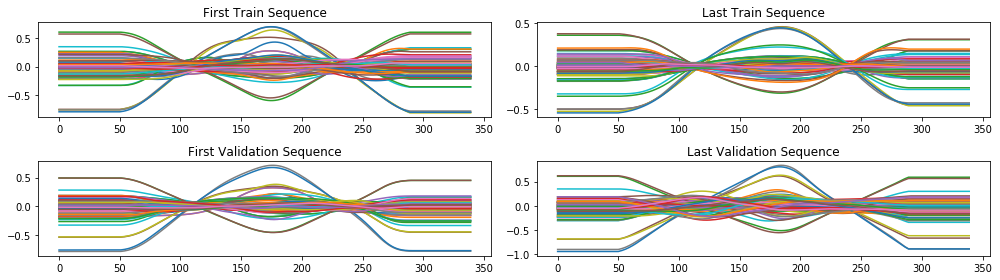

In [9]:
# Plot the first and last sequence in the training and validation data
%matplotlib inline
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(trainx[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(trainx[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(validx[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(validx[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()

In [10]:
# Input placeholder, 340x117 mvector
# Input placeholder, 340x117 mvector
input_seq = Input(shape=(timesteps[m-1]+100,n_dim))
encoded1 = LSTM(30,return_sequences = True)(input_seq)
encoded2 = LSTM(10,return_sequences = True)(encoded1)
# Encoded representation of the input, 340x4 vector
encoded = LSTM(4,return_sequences = True)(encoded2)
# Decoded reconstruction of the input,240x117 vector
decoded1 = LSTM(10,return_sequences = True)(encoded)
decoded2 = LSTM(30,return_sequences = True)(decoded1)
decoded = LSTM(n_dim, return_sequences = True)(decoded2)

# The model maps an input to its reconstruction
autoencoder = Model(inputs=input_seq, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 340, 117)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 340, 30)           17760     
_________________________________________________________________
lstm_2 (LSTM)                (None, 340, 10)           1640      
_________________________________________________________________
lstm_3 (LSTM)                (None, 340, 4)            240       
_________________________________________________________________
lstm_4 (LSTM)                (None, 340, 10)           600       
_________________________________________________________________
lstm_5 (LSTM)                (None, 340, 30)           4920      
_________________________________________________________________
lstm

In [11]:
# Measure the training time and implement early stoping
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 1000)

history = autoencoder.fit(trainx, trainx, epochs = 25000, batch_size = 10,
                validation_data=(validx, validx), callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

Instructions for updating:
Use tf.cast instead.
Train on 124 samples, validate on 56 samples
Epoch 1/25000
124/124 [==============================] - 32s 258ms/step - loss: 0.0203 - val_loss: 0.0162
Epoch 2/25000
124/124 [==============================] - 25s 201ms/step - loss: 0.0135 - val_loss: 0.0096
Epoch 3/25000
124/124 [==============================] - 28s 224ms/step - loss: 0.0088 - val_loss: 0.0067
Epoch 4/25000
124/124 [==============================] - 29s 237ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 5/25000
124/124 [==============================] - 28s 227ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 6/25000
124/124 [==============================] - 28s 224ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 7/25000
124/124 [==============================] - 28s 222ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 8/25000
124/124 [==============================] - 27s 217ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 9/25000
124/124 [==============================] - 27

124/124 [==============================] - 26s 212ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 151/25000
124/124 [==============================] - 28s 226ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 152/25000
124/124 [==============================] - 30s 244ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 153/25000
124/124 [==============================] - 30s 245ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 154/25000
124/124 [==============================] - 28s 226ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 155/25000
124/124 [==============================] - 29s 235ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 156/25000
124/124 [==============================] - 29s 231ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 157/25000
124/124 [==============================] - 30s 238ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 158/25000
124/124 [==============================] - 29s 231ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 159/25000
124/124 [===================

124/124 [==============================] - 28s 229ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 227/25000
124/124 [==============================] - 28s 228ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 228/25000
124/124 [==============================] - 28s 229ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 229/25000
124/124 [==============================] - 28s 230ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 230/25000
124/124 [==============================] - 29s 230ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 231/25000
124/124 [==============================] - 28s 227ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 232/25000
124/124 [==============================] - 28s 229ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 233/25000
124/124 [==============================] - 27s 218ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 234/25000
124/124 [==============================] - 28s 222ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 235/25000
124/124 [===================

124/124 [==============================] - 29s 231ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 303/25000
124/124 [==============================] - 27s 216ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 304/25000
124/124 [==============================] - 22s 181ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 305/25000
124/124 [==============================] - 22s 181ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 306/25000
124/124 [==============================] - 22s 180ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 307/25000
124/124 [==============================] - 22s 181ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 308/25000
124/124 [==============================] - 22s 180ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 309/25000
124/124 [==============================] - 22s 179ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 310/25000
124/124 [==============================] - 22s 181ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 311/25000
124/124 [===================

124/124 [==============================] - 34s 272ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 379/25000
124/124 [==============================] - 35s 279ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 380/25000
124/124 [==============================] - 29s 235ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 381/25000
124/124 [==============================] - 27s 215ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 382/25000
124/124 [==============================] - 29s 232ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 383/25000
124/124 [==============================] - 27s 221ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 384/25000
124/124 [==============================] - 26s 207ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 385/25000
124/124 [==============================] - 26s 211ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 386/25000
124/124 [==============================] - 27s 215ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 387/25000
124/124 [===================

124/124 [==============================] - 33s 263ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 455/25000
124/124 [==============================] - 34s 273ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 456/25000
124/124 [==============================] - 35s 282ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 457/25000
124/124 [==============================] - 34s 270ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 458/25000
124/124 [==============================] - 34s 273ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 459/25000
124/124 [==============================] - 34s 272ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 460/25000
124/124 [==============================] - 34s 277ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 461/25000
124/124 [==============================] - 34s 273ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 462/25000
124/124 [==============================] - 34s 274ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 463/25000
124/124 [===================

124/124 [==============================] - 29s 232ms/step - loss: 8.6441e-04 - val_loss: 0.0014
Epoch 602/25000
124/124 [==============================] - 28s 230ms/step - loss: 8.6636e-04 - val_loss: 0.0014
Epoch 603/25000
124/124 [==============================] - 28s 224ms/step - loss: 8.7981e-04 - val_loss: 0.0014
Epoch 604/25000
124/124 [==============================] - 28s 222ms/step - loss: 8.8355e-04 - val_loss: 0.0014
Epoch 605/25000
124/124 [==============================] - 28s 226ms/step - loss: 8.7294e-04 - val_loss: 0.0014
Epoch 606/25000
124/124 [==============================] - 27s 217ms/step - loss: 8.6015e-04 - val_loss: 0.0014
Epoch 607/25000
124/124 [==============================] - 27s 218ms/step - loss: 8.7193e-04 - val_loss: 0.0014
Epoch 608/25000
124/124 [==============================] - 27s 215ms/step - loss: 8.6838e-04 - val_loss: 0.0014
Epoch 609/25000
124/124 [==============================] - 27s 216ms/step - loss: 8.5528e-04 - val_loss: 0.0014
Epoch 61

124/124 [==============================] - 28s 227ms/step - loss: 7.5446e-04 - val_loss: 0.0014
Epoch 748/25000
124/124 [==============================] - 28s 227ms/step - loss: 7.5439e-04 - val_loss: 0.0014
Epoch 749/25000
124/124 [==============================] - 28s 227ms/step - loss: 7.4726e-04 - val_loss: 0.0013
Epoch 750/25000
124/124 [==============================] - 28s 227ms/step - loss: 7.4154e-04 - val_loss: 0.0013
Epoch 751/25000
124/124 [==============================] - 28s 224ms/step - loss: 7.4790e-04 - val_loss: 0.0013
Epoch 752/25000
124/124 [==============================] - 28s 227ms/step - loss: 7.4047e-04 - val_loss: 0.0013
Epoch 753/25000
124/124 [==============================] - 28s 227ms/step - loss: 7.4571e-04 - val_loss: 0.0013
Epoch 754/25000
124/124 [==============================] - 28s 227ms/step - loss: 7.4332e-04 - val_loss: 0.0013
Epoch 755/25000
124/124 [==============================] - 28s 227ms/step - loss: 7.3670e-04 - val_loss: 0.0013
Epoch 75

124/124 [==============================] - 28s 225ms/step - loss: 6.7613e-04 - val_loss: 0.0013
Epoch 894/25000
124/124 [==============================] - 28s 227ms/step - loss: 6.6448e-04 - val_loss: 0.0014
Epoch 895/25000
124/124 [==============================] - 28s 228ms/step - loss: 6.6760e-04 - val_loss: 0.0013
Epoch 896/25000
124/124 [==============================] - 28s 227ms/step - loss: 6.8627e-04 - val_loss: 0.0014
Epoch 897/25000
124/124 [==============================] - 28s 226ms/step - loss: 7.0339e-04 - val_loss: 0.0014
Epoch 898/25000
124/124 [==============================] - 28s 228ms/step - loss: 6.9570e-04 - val_loss: 0.0014
Epoch 899/25000
124/124 [==============================] - 28s 228ms/step - loss: 6.8604e-04 - val_loss: 0.0014
Epoch 900/25000
124/124 [==============================] - 28s 228ms/step - loss: 6.8742e-04 - val_loss: 0.0013
Epoch 901/25000
124/124 [==============================] - 28s 225ms/step - loss: 6.7981e-04 - val_loss: 0.0014
Epoch 90

Epoch 1039/25000
124/124 [==============================] - 30s 239ms/step - loss: 6.0335e-04 - val_loss: 0.0014
Epoch 1040/25000
124/124 [==============================] - 28s 226ms/step - loss: 6.0714e-04 - val_loss: 0.0014
Epoch 1041/25000
124/124 [==============================] - 29s 231ms/step - loss: 6.0735e-04 - val_loss: 0.0013
Epoch 1042/25000
124/124 [==============================] - 29s 232ms/step - loss: 6.0286e-04 - val_loss: 0.0014
Epoch 1043/25000
124/124 [==============================] - 28s 226ms/step - loss: 5.9955e-04 - val_loss: 0.0013
Epoch 1044/25000
124/124 [==============================] - 28s 227ms/step - loss: 5.9900e-04 - val_loss: 0.0014
Epoch 1045/25000
124/124 [==============================] - 28s 229ms/step - loss: 5.9604e-04 - val_loss: 0.0013
Epoch 1046/25000
124/124 [==============================] - 28s 226ms/step - loss: 5.8453e-04 - val_loss: 0.0013
Epoch 1047/25000
124/124 [==============================] - 28s 227ms/step - loss: 5.8478e-04 - 

124/124 [==============================] - 28s 226ms/step - loss: 5.5469e-04 - val_loss: 0.0014
Epoch 1184/25000
124/124 [==============================] - 28s 225ms/step - loss: 5.5392e-04 - val_loss: 0.0013
Epoch 1185/25000
124/124 [==============================] - 28s 224ms/step - loss: 5.4627e-04 - val_loss: 0.0013
Epoch 1186/25000
124/124 [==============================] - 28s 226ms/step - loss: 5.5029e-04 - val_loss: 0.0013
Epoch 1187/25000
124/124 [==============================] - 28s 225ms/step - loss: 5.4487e-04 - val_loss: 0.0013
Epoch 1188/25000
124/124 [==============================] - 28s 222ms/step - loss: 5.4837e-04 - val_loss: 0.0013
Epoch 1189/25000
124/124 [==============================] - 28s 225ms/step - loss: 5.5805e-04 - val_loss: 0.0013
Epoch 1190/25000
124/124 [==============================] - 28s 225ms/step - loss: 5.4548e-04 - val_loss: 0.0013
Epoch 1191/25000
124/124 [==============================] - 28s 229ms/step - loss: 5.4309e-04 - val_loss: 0.0013


124/124 [==============================] - 27s 220ms/step - loss: 5.2940e-04 - val_loss: 0.0014
Epoch 1328/25000
124/124 [==============================] - 28s 222ms/step - loss: 5.3620e-04 - val_loss: 0.0014
Epoch 1329/25000
124/124 [==============================] - 28s 222ms/step - loss: 5.3055e-04 - val_loss: 0.0013
Epoch 1330/25000
124/124 [==============================] - 28s 225ms/step - loss: 5.1475e-04 - val_loss: 0.0013
Epoch 1331/25000
124/124 [==============================] - 28s 229ms/step - loss: 5.1061e-04 - val_loss: 0.0013
Epoch 1332/25000
124/124 [==============================] - 28s 227ms/step - loss: 5.2030e-04 - val_loss: 0.0013
Epoch 1333/25000
124/124 [==============================] - 28s 225ms/step - loss: 5.2725e-04 - val_loss: 0.0013
Epoch 1334/25000
124/124 [==============================] - 28s 226ms/step - loss: 5.2612e-04 - val_loss: 0.0013
Epoch 1335/25000
124/124 [==============================] - 29s 231ms/step - loss: 5.2197e-04 - val_loss: 0.0013


124/124 [==============================] - 26s 209ms/step - loss: 4.7567e-04 - val_loss: 0.0013
Epoch 1472/25000
124/124 [==============================] - 26s 208ms/step - loss: 4.7675e-04 - val_loss: 0.0013
Epoch 1473/25000
124/124 [==============================] - 26s 209ms/step - loss: 4.7453e-04 - val_loss: 0.0013
Epoch 1474/25000
124/124 [==============================] - 26s 210ms/step - loss: 4.7221e-04 - val_loss: 0.0013
Epoch 1475/25000
124/124 [==============================] - 26s 206ms/step - loss: 4.7409e-04 - val_loss: 0.0013
Epoch 1476/25000
124/124 [==============================] - 26s 210ms/step - loss: 4.7990e-04 - val_loss: 0.0013
Epoch 1477/25000
124/124 [==============================] - 26s 209ms/step - loss: 4.8490e-04 - val_loss: 0.0013
Epoch 1478/25000
124/124 [==============================] - 26s 209ms/step - loss: 4.8710e-04 - val_loss: 0.0013
Epoch 1479/25000
124/124 [==============================] - 26s 212ms/step - loss: 4.8729e-04 - val_loss: 0.0013


124/124 [==============================] - 32s 254ms/step - loss: 4.6652e-04 - val_loss: 0.0013
Epoch 1616/25000
124/124 [==============================] - 22s 175ms/step - loss: 4.7210e-04 - val_loss: 0.0013
Epoch 1617/25000
124/124 [==============================] - 880s 7s/step - loss: 4.6495e-04 - val_loss: 0.0013
Epoch 1618/25000
124/124 [==============================] - 33s 265ms/step - loss: 4.5652e-04 - val_loss: 0.0013
Epoch 1619/25000
124/124 [==============================] - 22s 179ms/step - loss: 4.4899e-04 - val_loss: 0.0013
Epoch 1620/25000
124/124 [==============================] - 1413s 11s/step - loss: 4.5025e-04 - val_loss: 0.0013
Epoch 1621/25000
124/124 [==============================] - 21s 171ms/step - loss: 4.5398e-04 - val_loss: 0.0013
Epoch 1622/25000
124/124 [==============================] - 22s 180ms/step - loss: 4.4808e-04 - val_loss: 0.0013
Epoch 1623/25000
124/124 [==============================] - 1859s 15s/step - loss: 4.4785e-04 - val_loss: 0.0013
Ep

124/124 [==============================] - 37s 296ms/step - loss: 4.3848e-04 - val_loss: 0.0012
Epoch 1760/25000
124/124 [==============================] - 37s 295ms/step - loss: 4.3486e-04 - val_loss: 0.0012
Epoch 1761/25000
124/124 [==============================] - 38s 305ms/step - loss: 4.3094e-04 - val_loss: 0.0012
Epoch 1762/25000
124/124 [==============================] - 37s 300ms/step - loss: 4.3077e-04 - val_loss: 0.0012
Epoch 1763/25000
124/124 [==============================] - 37s 298ms/step - loss: 4.3207e-04 - val_loss: 0.0012
Epoch 1764/25000
124/124 [==============================] - 37s 300ms/step - loss: 4.3249e-04 - val_loss: 0.0012
Epoch 1765/25000
124/124 [==============================] - 36s 294ms/step - loss: 4.2851e-04 - val_loss: 0.0012
Epoch 1766/25000
124/124 [==============================] - 37s 299ms/step - loss: 4.2610e-04 - val_loss: 0.0012
Epoch 1767/25000
124/124 [==============================] - 38s 306ms/step - loss: 4.2747e-04 - val_loss: 0.0012


124/124 [==============================] - 27s 218ms/step - loss: 4.1321e-04 - val_loss: 0.0012
Epoch 1904/25000
124/124 [==============================] - 30s 243ms/step - loss: 4.1167e-04 - val_loss: 0.0013
Epoch 1905/25000
124/124 [==============================] - 26s 208ms/step - loss: 4.0962e-04 - val_loss: 0.0012
Epoch 1906/25000
124/124 [==============================] - 26s 211ms/step - loss: 4.1299e-04 - val_loss: 0.0012
Epoch 1907/25000
124/124 [==============================] - 21s 173ms/step - loss: 4.1193e-04 - val_loss: 0.0012
Epoch 1908/25000
124/124 [==============================] - 24s 197ms/step - loss: 4.0627e-04 - val_loss: 0.0012
Epoch 1909/25000
124/124 [==============================] - 23s 184ms/step - loss: 4.0190e-04 - val_loss: 0.0013
Epoch 1910/25000
124/124 [==============================] - 25s 201ms/step - loss: 4.0232e-04 - val_loss: 0.0013
Epoch 1911/25000
124/124 [==============================] - 23s 187ms/step - loss: 4.0051e-04 - val_loss: 0.0012


124/124 [==============================] - 26s 209ms/step - loss: 4.0974e-04 - val_loss: 0.0012
Epoch 2048/25000
124/124 [==============================] - 23s 182ms/step - loss: 4.0929e-04 - val_loss: 0.0012
Epoch 2049/25000
124/124 [==============================] - 21s 169ms/step - loss: 4.0135e-04 - val_loss: 0.0013
Epoch 2050/25000
124/124 [==============================] - 22s 175ms/step - loss: 3.9878e-04 - val_loss: 0.0013
Epoch 2051/25000
124/124 [==============================] - 23s 185ms/step - loss: 3.9230e-04 - val_loss: 0.0013
Epoch 2052/25000
124/124 [==============================] - 21s 167ms/step - loss: 3.9844e-04 - val_loss: 0.0012
Epoch 2053/25000
124/124 [==============================] - 23s 185ms/step - loss: 3.9452e-04 - val_loss: 0.0012
Epoch 2054/25000
124/124 [==============================] - 25s 198ms/step - loss: 3.9217e-04 - val_loss: 0.0013
Epoch 2055/25000
124/124 [==============================] - 22s 175ms/step - loss: 3.9341e-04 - val_loss: 0.0012


124/124 [==============================] - 24s 191ms/step - loss: 3.8115e-04 - val_loss: 0.0012
Epoch 2192/25000
124/124 [==============================] - 24s 196ms/step - loss: 3.8027e-04 - val_loss: 0.0012
Epoch 2193/25000
124/124 [==============================] - 24s 192ms/step - loss: 3.8538e-04 - val_loss: 0.0012
Epoch 2194/25000
124/124 [==============================] - 25s 203ms/step - loss: 3.8368e-04 - val_loss: 0.0012
Epoch 2195/25000
124/124 [==============================] - 21s 173ms/step - loss: 3.7801e-04 - val_loss: 0.0012
Epoch 2196/25000
124/124 [==============================] - 21s 169ms/step - loss: 3.8285e-04 - val_loss: 0.0012
Epoch 2197/25000
124/124 [==============================] - 26s 213ms/step - loss: 3.8923e-04 - val_loss: 0.0012
Epoch 2198/25000
124/124 [==============================] - 26s 212ms/step - loss: 3.8880e-04 - val_loss: 0.0012
Epoch 2199/25000
124/124 [==============================] - 27s 217ms/step - loss: 3.8568e-04 - val_loss: 0.0012


124/124 [==============================] - 22s 177ms/step - loss: 3.8373e-04 - val_loss: 0.0012
Epoch 2336/25000
124/124 [==============================] - 22s 177ms/step - loss: 3.7573e-04 - val_loss: 0.0012
Epoch 2337/25000
124/124 [==============================] - 22s 176ms/step - loss: 3.7339e-04 - val_loss: 0.0012
Epoch 2338/25000
124/124 [==============================] - 22s 176ms/step - loss: 3.7066e-04 - val_loss: 0.0012
Epoch 2339/25000
124/124 [==============================] - 22s 177ms/step - loss: 3.6582e-04 - val_loss: 0.0012
Epoch 2340/25000
124/124 [==============================] - 21s 172ms/step - loss: 3.6098e-04 - val_loss: 0.0012
Epoch 2341/25000
124/124 [==============================] - 22s 174ms/step - loss: 3.5793e-04 - val_loss: 0.0012
Epoch 2342/25000
124/124 [==============================] - 22s 175ms/step - loss: 3.5793e-04 - val_loss: 0.0012
Epoch 2343/25000
124/124 [==============================] - 22s 175ms/step - loss: 3.5497e-04 - val_loss: 0.0012


124/124 [==============================] - 21s 170ms/step - loss: 3.7503e-04 - val_loss: 0.0012
Epoch 2480/25000
124/124 [==============================] - 21s 171ms/step - loss: 3.5763e-04 - val_loss: 0.0012
Epoch 2481/25000
124/124 [==============================] - 21s 172ms/step - loss: 3.5002e-04 - val_loss: 0.0012
Epoch 2482/25000
124/124 [==============================] - 21s 169ms/step - loss: 3.4689e-04 - val_loss: 0.0012
Epoch 2483/25000
124/124 [==============================] - 21s 172ms/step - loss: 3.4051e-04 - val_loss: 0.0012
Epoch 2484/25000
124/124 [==============================] - 21s 171ms/step - loss: 3.4361e-04 - val_loss: 0.0012
Epoch 2485/25000
124/124 [==============================] - 21s 169ms/step - loss: 3.4311e-04 - val_loss: 0.0012
Epoch 2486/25000
124/124 [==============================] - 21s 171ms/step - loss: 3.4068e-04 - val_loss: 0.0012
Epoch 2487/25000
124/124 [==============================] - 21s 172ms/step - loss: 3.4117e-04 - val_loss: 0.0012


124/124 [==============================] - 20s 162ms/step - loss: 9.0475e-04 - val_loss: 0.0016
Epoch 2624/25000
124/124 [==============================] - 20s 163ms/step - loss: 8.4462e-04 - val_loss: 0.0015
Epoch 2625/25000
124/124 [==============================] - 21s 171ms/step - loss: 6.5680e-04 - val_loss: 0.0013
Epoch 2626/25000
124/124 [==============================] - 21s 170ms/step - loss: 5.3911e-04 - val_loss: 0.0013
Epoch 2627/25000
124/124 [==============================] - 20s 164ms/step - loss: 4.4240e-04 - val_loss: 0.0012
Epoch 2628/25000
124/124 [==============================] - 20s 159ms/step - loss: 4.0188e-04 - val_loss: 0.0012
Epoch 2629/25000
124/124 [==============================] - 20s 163ms/step - loss: 3.7343e-04 - val_loss: 0.0012
Epoch 2630/25000
124/124 [==============================] - 20s 162ms/step - loss: 3.5631e-04 - val_loss: 0.0012
Epoch 2631/25000
124/124 [==============================] - 20s 165ms/step - loss: 3.4762e-04 - val_loss: 0.0012


124/124 [==============================] - 21s 167ms/step - loss: 3.5751e-04 - val_loss: 0.0012
Epoch 2768/25000
124/124 [==============================] - 21s 173ms/step - loss: 3.7015e-04 - val_loss: 0.0013
Epoch 2769/25000
124/124 [==============================] - 21s 167ms/step - loss: 3.6844e-04 - val_loss: 0.0012
Epoch 2770/25000
124/124 [==============================] - 21s 171ms/step - loss: 3.6392e-04 - val_loss: 0.0012
Epoch 2771/25000
124/124 [==============================] - 21s 172ms/step - loss: 3.4935e-04 - val_loss: 0.0013
Epoch 2772/25000
124/124 [==============================] - 21s 170ms/step - loss: 3.4355e-04 - val_loss: 0.0012
Epoch 2773/25000
124/124 [==============================] - 22s 174ms/step - loss: 3.3808e-04 - val_loss: 0.0012
Epoch 2774/25000
124/124 [==============================] - 21s 171ms/step - loss: 3.4365e-04 - val_loss: 0.0012
Epoch 2775/25000
124/124 [==============================] - 21s 170ms/step - loss: 3.4183e-04 - val_loss: 0.0013


124/124 [==============================] - 22s 174ms/step - loss: 3.1229e-04 - val_loss: 0.0012
Epoch 2912/25000
124/124 [==============================] - 21s 172ms/step - loss: 3.1254e-04 - val_loss: 0.0012
Epoch 2913/25000
124/124 [==============================] - 21s 166ms/step - loss: 3.1342e-04 - val_loss: 0.0012
Epoch 2914/25000
124/124 [==============================] - 21s 167ms/step - loss: 3.1543e-04 - val_loss: 0.0012
Epoch 2915/25000
124/124 [==============================] - 21s 166ms/step - loss: 3.1523e-04 - val_loss: 0.0012
Epoch 2916/25000
124/124 [==============================] - 21s 166ms/step - loss: 3.1053e-04 - val_loss: 0.0012
Epoch 2917/25000
124/124 [==============================] - 21s 166ms/step - loss: 3.0886e-04 - val_loss: 0.0012
Epoch 2918/25000
124/124 [==============================] - 20s 161ms/step - loss: 3.0816e-04 - val_loss: 0.0012
Epoch 2919/25000
124/124 [==============================] - 20s 161ms/step - loss: 3.0669e-04 - val_loss: 0.0012


124/124 [==============================] - 20s 164ms/step - loss: 3.2088e-04 - val_loss: 0.0012
Epoch 3056/25000
124/124 [==============================] - 20s 162ms/step - loss: 3.1938e-04 - val_loss: 0.0012
Epoch 3057/25000
124/124 [==============================] - 20s 164ms/step - loss: 3.2018e-04 - val_loss: 0.0012
Epoch 3058/25000
124/124 [==============================] - 20s 163ms/step - loss: 3.2699e-04 - val_loss: 0.0012
Epoch 3059/25000
124/124 [==============================] - 20s 164ms/step - loss: 3.2631e-04 - val_loss: 0.0012
Epoch 3060/25000
124/124 [==============================] - 20s 164ms/step - loss: 3.3502e-04 - val_loss: 0.0013
Epoch 3061/25000
124/124 [==============================] - 20s 165ms/step - loss: 6.2653e-04 - val_loss: 0.0015
Epoch 3062/25000
124/124 [==============================] - 20s 161ms/step - loss: 9.3227e-04 - val_loss: 0.0015
Epoch 3063/25000
124/124 [==============================] - 20s 163ms/step - loss: 0.0011 - val_loss: 0.0016
Epoc

124/124 [==============================] - 23s 189ms/step - loss: 3.1925e-04 - val_loss: 0.0012
Epoch 3200/25000
124/124 [==============================] - 23s 185ms/step - loss: 3.1538e-04 - val_loss: 0.0012
Epoch 3201/25000
124/124 [==============================] - 23s 182ms/step - loss: 3.1293e-04 - val_loss: 0.0012
Epoch 3202/25000
124/124 [==============================] - 23s 183ms/step - loss: 3.1150e-04 - val_loss: 0.0012
Epoch 3203/25000
124/124 [==============================] - 23s 186ms/step - loss: 3.1150e-04 - val_loss: 0.0012
Epoch 3204/25000
124/124 [==============================] - 22s 174ms/step - loss: 3.0888e-04 - val_loss: 0.0012
Epoch 3205/25000
124/124 [==============================] - 20s 162ms/step - loss: 3.1313e-04 - val_loss: 0.0012
Epoch 3206/25000
124/124 [==============================] - 20s 165ms/step - loss: 3.1261e-04 - val_loss: 0.0012
Epoch 3207/25000
124/124 [==============================] - 21s 166ms/step - loss: 3.1012e-04 - val_loss: 0.0012


124/124 [==============================] - 20s 162ms/step - loss: 3.0685e-04 - val_loss: 0.0012
Epoch 3344/25000
124/124 [==============================] - 20s 163ms/step - loss: 3.1543e-04 - val_loss: 0.0012
Epoch 3345/25000
124/124 [==============================] - 20s 164ms/step - loss: 3.2690e-04 - val_loss: 0.0012
Epoch 3346/25000
124/124 [==============================] - 20s 164ms/step - loss: 3.2521e-04 - val_loss: 0.0012
Epoch 3347/25000
124/124 [==============================] - 20s 163ms/step - loss: 3.3419e-04 - val_loss: 0.0012
Epoch 3348/25000
124/124 [==============================] - 20s 162ms/step - loss: 3.3090e-04 - val_loss: 0.0012
Epoch 3349/25000
124/124 [==============================] - 20s 163ms/step - loss: 3.2701e-04 - val_loss: 0.0012
Epoch 3350/25000
124/124 [==============================] - 20s 163ms/step - loss: 3.2595e-04 - val_loss: 0.0012
Epoch 3351/25000
124/124 [==============================] - 20s 163ms/step - loss: 3.2516e-04 - val_loss: 0.0012


124/124 [==============================] - 20s 160ms/step - loss: 2.9892e-04 - val_loss: 0.0012
Epoch 3488/25000
124/124 [==============================] - 20s 159ms/step - loss: 3.0553e-04 - val_loss: 0.0012
Epoch 3489/25000
124/124 [==============================] - 21s 167ms/step - loss: 3.0669e-04 - val_loss: 0.0012
Epoch 3490/25000
124/124 [==============================] - 20s 163ms/step - loss: 2.9762e-04 - val_loss: 0.0012
Epoch 3491/25000
124/124 [==============================] - 20s 163ms/step - loss: 2.9391e-04 - val_loss: 0.0012
Epoch 3492/25000
124/124 [==============================] - 20s 162ms/step - loss: 2.9242e-04 - val_loss: 0.0012
Epoch 3493/25000
124/124 [==============================] - 20s 164ms/step - loss: 2.9126e-04 - val_loss: 0.0012
Epoch 3494/25000
124/124 [==============================] - 20s 161ms/step - loss: 2.8750e-04 - val_loss: 0.0012
Epoch 3495/25000
124/124 [==============================] - 20s 165ms/step - loss: 2.8757e-04 - val_loss: 0.0012


Epoch 3560/25000
124/124 [==============================] - 19s 152ms/step - loss: 5.1830e-04 - val_loss: 0.0013
Epoch 3561/25000
124/124 [==============================] - 19s 150ms/step - loss: 5.0311e-04 - val_loss: 0.0013
Epoch 3562/25000
124/124 [==============================] - 19s 151ms/step - loss: 4.9327e-04 - val_loss: 0.0013
Epoch 3563/25000
124/124 [==============================] - 321s 3s/step - loss: 4.8019e-04 - val_loss: 0.0013
Epoch 3564/25000
124/124 [==============================] - 19s 151ms/step - loss: 4.6995e-04 - val_loss: 0.0013
Epoch 3565/25000
124/124 [==============================] - 19s 152ms/step - loss: 4.6492e-04 - val_loss: 0.0013
Epoch 3566/25000
124/124 [==============================] - 19s 152ms/step - loss: 4.6337e-04 - val_loss: 0.0013
Epoch 3567/25000
124/124 [==============================] - 19s 152ms/step - loss: 4.4746e-04 - val_loss: 0.0013
Epoch 3568/25000
124/124 [==============================] - 19s 152ms/step - loss: 4.3289e-04 - va

124/124 [==============================] - 20s 162ms/step - loss: 2.9440e-04 - val_loss: 0.0012
Epoch 3705/25000
124/124 [==============================] - 20s 159ms/step - loss: 3.0221e-04 - val_loss: 0.0012
Epoch 3706/25000
124/124 [==============================] - 19s 155ms/step - loss: 3.2996e-04 - val_loss: 0.0012
Epoch 3707/25000
124/124 [==============================] - 19s 153ms/step - loss: 3.2753e-04 - val_loss: 0.0012
Epoch 3708/25000
124/124 [==============================] - 19s 154ms/step - loss: 3.1002e-04 - val_loss: 0.0012
Epoch 3709/25000
124/124 [==============================] - 19s 153ms/step - loss: 3.0566e-04 - val_loss: 0.0012
Epoch 3710/25000
124/124 [==============================] - 19s 157ms/step - loss: 2.9531e-04 - val_loss: 0.0012
Epoch 3711/25000
124/124 [==============================] - 19s 152ms/step - loss: 2.9472e-04 - val_loss: 0.0012
Epoch 3712/25000
124/124 [==============================] - 20s 163ms/step - loss: 2.9116e-04 - val_loss: 0.0012


124/124 [==============================] - 19s 157ms/step - loss: 2.7543e-04 - val_loss: 0.0012
Epoch 3849/25000
124/124 [==============================] - 20s 164ms/step - loss: 2.7333e-04 - val_loss: 0.0012
Epoch 3850/25000
124/124 [==============================] - 20s 158ms/step - loss: 2.7233e-04 - val_loss: 0.0012
Epoch 3851/25000
124/124 [==============================] - 19s 157ms/step - loss: 2.7118e-04 - val_loss: 0.0012
Epoch 3852/25000
124/124 [==============================] - 20s 158ms/step - loss: 2.7190e-04 - val_loss: 0.0012
Epoch 3853/25000
124/124 [==============================] - 20s 159ms/step - loss: 2.7343e-04 - val_loss: 0.0012
Epoch 3854/25000
124/124 [==============================] - 20s 158ms/step - loss: 2.7380e-04 - val_loss: 0.0012
Epoch 3855/25000
124/124 [==============================] - 20s 158ms/step - loss: 2.7325e-04 - val_loss: 0.0012
Epoch 3856/25000
124/124 [==============================] - 20s 160ms/step - loss: 2.6900e-04 - val_loss: 0.0012


124/124 [==============================] - 19s 154ms/step - loss: 3.7088e-04 - val_loss: 0.0013
Epoch 3993/25000
124/124 [==============================] - 19s 154ms/step - loss: 3.5381e-04 - val_loss: 0.0012
Epoch 3994/25000
124/124 [==============================] - 19s 154ms/step - loss: 3.3690e-04 - val_loss: 0.0012
Epoch 3995/25000
124/124 [==============================] - 19s 155ms/step - loss: 3.2544e-04 - val_loss: 0.0012
Epoch 3996/25000
124/124 [==============================] - 20s 159ms/step - loss: 3.2129e-04 - val_loss: 0.0012
Epoch 3997/25000
124/124 [==============================] - 20s 161ms/step - loss: 3.1617e-04 - val_loss: 0.0012
Epoch 3998/25000
124/124 [==============================] - 20s 158ms/step - loss: 3.1087e-04 - val_loss: 0.0012
Epoch 3999/25000
124/124 [==============================] - 20s 160ms/step - loss: 3.0881e-04 - val_loss: 0.0012
Epoch 4000/25000
124/124 [==============================] - 21s 167ms/step - loss: 3.0543e-04 - val_loss: 0.0012


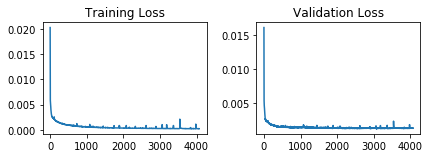

Training loss 0.00026811925589197106
Validation loss 0.0011542576352699793


In [12]:
# Plot the results
plt.figure(1)
plt.subplot(221)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.subplot(222)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.tight_layout()
plt.show()

# Print the minimum loss
print("Training loss", np.min(history.history['loss']))
print("Validation loss",np.min(history.history['val_loss']))

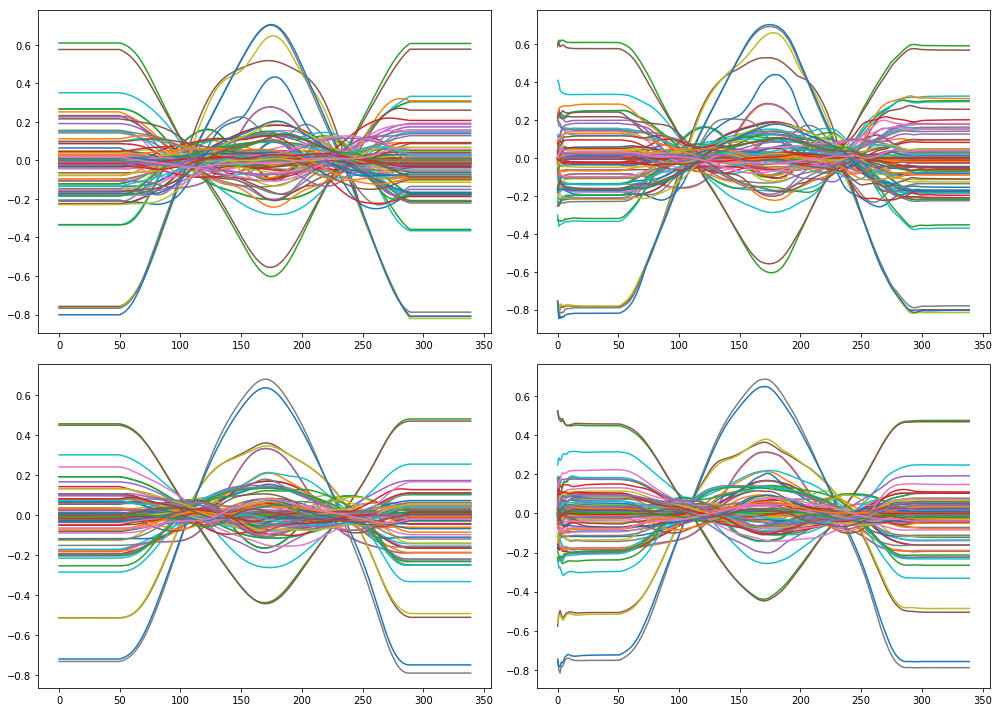

In [13]:
# Encode and decode a few sequences
decoded_seqs = autoencoder.predict(trainx)
# Plot some results
n = 2  # how many sequences we will display
plt.figure(figsize = (14,10))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(trainx[i])
    
    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(decoded_seqs[i])
plt.tight_layout()
plt.show()

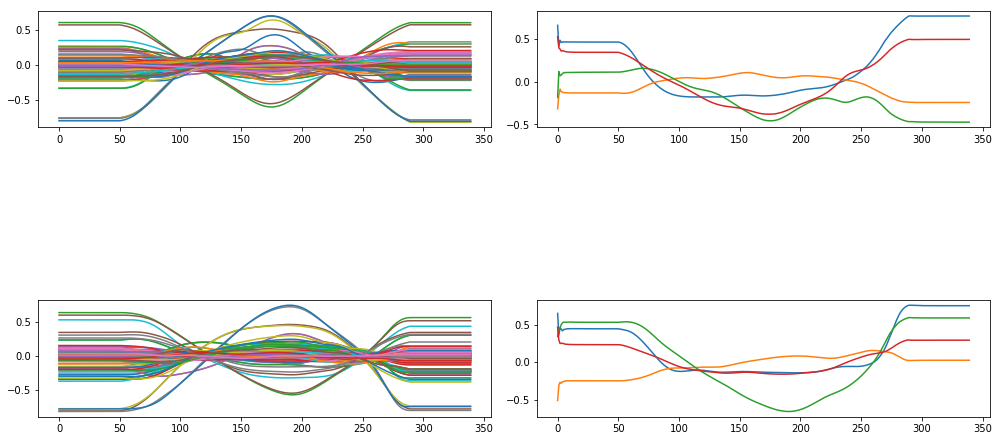

In [14]:
# Create an encoder model
# This model maps an input to its encoded representation
encoder = Model(inputs=input_seq, outputs=encoded)

# Test the encoder model
encoded_seqs = encoder.predict(trainx)

# Plot the results
n = 4  # how many sequences we will display
plt.figure(figsize = (14,8))
for i in range(0,n,n//2):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(trainx[i])
    
    # display reduced sequence
    plt.subplot(n, 2, 2*i+2)
    plt.plot(encoded_seqs[i])
plt.tight_layout()
plt.show()

In [15]:
autoencoder.save_weights('M'+str(m)+'_Encoder_Decoder.h5')

In [16]:
# Reduce the data to 240 data points
output_train_data = encoded_seqs[:,50:-50,:]
print(output_train_data.shape, 'encoded train sequences shape')

# Do the same for the validation sequences
encoded_seqs_validx = encoder.predict(validx)
output_valid_data = encoded_seqs_validx[:,50:-50,:]
print(output_valid_data.shape, 'encoded validation sequences shape')

(124, 240, 4) encoded train sequences shape
(56, 240, 4) encoded validation sequences shape


In [17]:
# recover structure of the data
L1 = int(output_train_data.shape[0]/2)
L2 =int(output_valid_data.shape[0]/2)
Correct_data_reduced = np.concatenate((output_train_data[0:L1,:,:],output_valid_data[0:L2,:,:]))
Incorrect_data_reduced = np.concatenate((output_train_data[L1:,:,:],output_valid_data[L2:,:,:]))
print(Correct_data_reduced.shape)
print(Incorrect_data_reduced.shape)
# recover the order of the data
c_Correct_data_reduced=np.zeros((nr[m-1],timesteps[m-1],4))
c_Incorrect_data_reduced=np.zeros((nr[m-1],timesteps[m-1],4))
for i in range(nr[m-1]):
    c_Correct_data_reduced[order_correct[i],:,:] = Correct_data_reduced[i,:,:]
    c_Incorrect_data_reduced[order_incorrect[i],:,:] = Incorrect_data_reduced[i,:,:]
Correct_data_reduced=c_Correct_data_reduced
Incorrect_data_reduced=c_Incorrect_data_reduced

(90, 240, 4)
(90, 240, 4)


In [18]:
# Reshape the encoded sequences, because savetxt saves only two dimensional data
csv_correct = Correct_data_reduced.reshape(Correct_data_reduced.shape[0],\
                                           Correct_data_reduced.shape[1]*Correct_data_reduced.shape[2])
print('Correct reduced data for saving in CSV',csv_correct.shape)
# Save the  data in the file M1_Train_EncDec.csv
np.savetxt('M'+str(m)+'_Correct_EncDec.csv', csv_correct, fmt='%.5f',delimiter=',')

Correct reduced data for saving in CSV (90, 960)


In [19]:
# Reshape the encoded sequences, because savetxt saves only two dimensional data
csv_incorrect = Incorrect_data_reduced.reshape(Incorrect_data_reduced.shape[0],\
                                          Incorrect_data_reduced.shape[1]*Incorrect_data_reduced.shape[2])
print('encoded test sequences shape for saving',csv_incorrect.shape,)
# Save the  data in the file M1_Test_EncDec.csv
np.savetxt('M'+str(m)+'_Correct_EncDec.csv', csv_incorrect, fmt='%.5f',delimiter=',')

encoded test sequences shape for saving (90, 960)
